# betelbot

This notebook is a modified version of code from [betelbot](https://github.com/hippke/betelbot) by Michael Hippke.

With minimal changes to run it in a notebook.

In [7]:
import numpy as np
import datetime
from matplotlib import pyplot as plt
from wotan import flatten
import requests
from bs4 import BeautifulSoup
from astropy.stats import biweight_location

In [8]:
def build_string(days_ago, mag):
    print('Building string...')
    data_last24hrs = np.where(days_ago<1)
    data_last1_6_days = np.where((days_ago<6) & (days_ago>1))
    n_obs_last24hrs = np.size(mag[data_last24hrs])
    n_obs_last1_6_days = np.size(mag[data_last1_6_days])
    mean_last24hrs = biweight_location(mag[data_last24hrs])
    mean_last1_6_days = biweight_location(mag[data_last1_6_days])
    stdev = np.std(mag[data_last24hrs]) / np.sqrt(n_obs_last24hrs) \
        + np.std(mag[data_last1_6_days]) / np.sqrt(n_obs_last1_6_days)
    diff = mean_last24hrs - mean_last1_6_days
    sigma = diff / stdev

    if n_obs_last24hrs < 1 or n_obs_last1_6_days < 2:
        print('Not enough observations. Abort.')
        return None
    else:

        if diff > 0:
            changeword = 'dimmer'
        else:
            changeword = 'brighter'

        mag_text = "My visual mag from last night was " + \
            str(format(mean_last24hrs, '.2f')) + \
            ' (robust mean of ' + \
            str(n_obs_last24hrs) + \
            ' observations). '

        change_text = 'That is ' + \
            format(abs(diff), '.2f') + \
            ' mag ' + \
            changeword + \
            ' than the robust mean of the 5 previous nights (n=' + \
            str(n_obs_last1_6_days) + \
            ', ' + \
            format(abs(sigma), '.1f') + \
            'σ). #Betelgeuse'

        text = mag_text + change_text
        print(text)
        return text

In [9]:
def get_mags_from_AAVSO(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    rows = soup.select('tbody tr')
    dates = []
    mags = []
    for row in rows:
        string = '' + row.text
        string = string.split('\n')
        try:
            date = float(string[3])
            mag = float(string[5])
            # Remove crap
            if mag < 3:
                dates.append(date)
                mags.append(mag)
        except:
            pass
    return np.array(dates), np.array(mags)

In [10]:
def make_plot(days_ago, dates, mag):
    print('Making plot...')
    time_span = np.max(dates) - np.min(dates)
    flatten_lc, trend_lc = flatten(
        days_ago,
        mag,
        method='lowess',
        window_length=time_span/5,
        return_trend=True,
        )
    plt.scatter(days_ago, mag, s=5, color='blue', alpha=0.5)

    plt.scatter(days_ago1, all_mags1, s=10, color='black', alpha=0.8, marker="x")
    plt.xlabel('Days before today')
    plt.ylabel('Visual magnitude')
    #mid = biweight_location(mag)
    mid = 1.10
    plt.ylim(mid-1, mid+1)
    plt.xlim(-1, 20)
    plt.plot(days_ago, trend_lc, color='red', linewidth=1)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    date_text = datetime.datetime.now().strftime("%d %b %Y")
    data_last24hrs = np.where(days_ago<1)
    mean_last24hrs = biweight_location(mag[data_last24hrs])
    lumi = str(format(mean_last24hrs, '.2f'))
    plt.text(19.5, mid+1-0.25, "AAVSO observations visual (by-eye) in blue", color='blue')
    plt.text(19.5, mid+1-0.15, "AAVSO observations from CCDs in black", color='black')
    plt.text(19.5, mid+1-0.05, "LOESS trend in red", color='red')
    plt.text(19.5, mid-1+0.1, '#Betelgeuse brightness ' + lumi + " mag on " + date_text + " by @betelbot")
    plt.savefig(plot_file, bbox_inches='tight', dpi=300)
    print('Done.')

In [11]:
def get_mags_from_AAVSO_V(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    rows = soup.select('tbody tr')
    dates = []
    mags = []
    for row in rows:
        string = '' + row.text
        string = string.split('\n')
        try:
            date = float(string[3])
            mag = float(string[5])
            band = string[7]
            #print(date, mag, band)
            if band == "V":
                dates.append(date)
                mags.append(mag)
                #print(date, mag)
            #print(mag)
        except:
            pass
    return np.array(dates), np.array(mags)

In [12]:
# CCDs
url_base = 'https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=dslr+ptg+pep+ccd+visdig&page='
baseline_mag = 0.5
pages = np.arange(1, 2, 1)
all_dates1 = np.array([])
all_mags1 = np.array([])
for page in pages:
    url = url_base + str(page)
    #print(url)
    dates, mags = get_mags_from_AAVSO_V(url)
    print(dates, mags)
    all_dates1 = np.concatenate((all_dates1, dates))
    all_mags1 = np.concatenate((all_mags1, mags))
    
days_ago1 = np.max(all_dates1) - all_dates1
print(all_dates1, all_mags1)

[2458963.3017   2458963.2968   2458963.295    2458962.3084
 2458962.3064   2458961.3037   2458959.52727  2458958.6236
 2458957.52629  2458957.294    2458957.2921   2458956.2951
 2458955.3094   2458955.2967   2458954.6766   2458954.6223
 2458952.53422  2458950.2856   2458950.2834   2458949.6755
 2458949.6207   2458949.2792   2458948.2886   2458948.2864
 2458947.291    2458946.2841   2458946.2748   2458945.3137
 2458945.2872   2458945.2848   2458944.3116   2458944.2826
 2458944.2806   2458943.6179   2458943.3148   2458942.6498
 2458942.5838   2458942.2924   2458942.2904   2458941.288
 2458941.2861   2458940.2892   2458940.287    2458939.2789
 2458939.2768   2458938.6145   2458937.5368   2458934.6578
 2458933.288605 2458933.2731   2458933.2708   2458932.6513
 2458932.3039   2458931.53472  2458931.52741  2458931.3264
 2458931.296645 2458930.6576   2458930.54324 ] [0.456  0.409  0.41   0.342  0.335  0.43   0.413  0.487  0.448  0.348
 0.386  0.558  0.48   0.517  0.543  0.504  0.534  0.539  0

https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=1
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=2
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=3
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=4
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=5
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=6
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=7
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=8
https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page=9
Building string...
My visual mag from last night was 0.53 (robust mean of 2 observations). That is 0.03 mag dimmer than the robust mean 

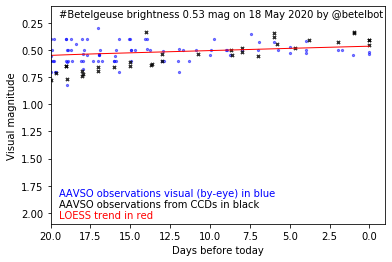

In [13]:
# Pull the last 10 pages from AAVSO and collate the dates and mags
plot_file = 'plot20d.png'
url_base = 'https://www.aavso.org/apps/webobs/results/?star=betelgeuse&num_results=200&obs_types=vis&page='
pages = np.arange(1, 10, 1)
all_dates = np.array([])
all_mags = np.array([])
for page in pages:
    url = url_base + str(page)
    print(url)
    dates, mags = get_mags_from_AAVSO(url)
    all_dates = np.concatenate((all_dates, dates))
    all_mags = np.concatenate((all_mags, mags))
dates = all_dates
mags = all_mags
days_ago = np.max(dates) - dates
text = build_string(days_ago, mags)
if text is not None:
    make_plot(days_ago, dates, mags)